In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
batch_size = 1024
n_bins = 2 ** 8

train_dataset = dsets.MNIST(
    root='./MNIST/', 
    train=True, 
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        lambda x: x + torch.zeros_like(x).uniform_(0, 1. / n_bins)
    ]),
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [224]:
class ActNorm(nn.Module):
    def __init__(self, h, w, c):
        super().__init__()
        self.shape = (h, w, c)
        self.initialized = False
        self.weights = nn.Parameter(torch.Tensor(c))
        self.bias = nn.Parameter(torch.Tensor(c))
        
    def forward(self, inp, logdet):
        if not self.initialized:
            c = self.shape[-1]
            self.weights.data = 1/inp.transpose(0, 1).contiguous().view(c, -1).std(1)
            self.bias.data = -(inp * self.weights[..., None, None]).transpose(0, 1).contiguous().view(c, -1).mean(1)
            self.initialized = True
        
        return inp * self.weights[..., None, None] + self.bias[..., None, None], logdet + self.shape[0] * self.shape[1] * torch.sum(torch.abs(self.weights))
    
    def reverse(self, out):
        return (out - self.bias[..., None, None]) / self.weights[..., None, None]

class InvertibleConv(nn.Module):
    def __init__(self, h, w, c):
        super().__init__()
        self.shape = (h, w, c)
        self.weight = nn.Parameter(torch.from_numpy(np.linalg.qr(np.random.randn(c, c))[0]).float())
                                    
    def forward(self, inp, logdet):
        return torch.einsum("abcd,eb->aecd", (inp, self.weight)), logdet + self.shape[0] * self.shape[1] * torch.log(torch.abs(torch.det(self.weight)))
    
    def reverse(self, out):
        return torch.einsum("abcd,eb->aecd", (out, torch.inverse(self.weight)))

class AffineCoupling(nn.Module):
    def __init__(self, h, w, c):
        super().__init__()
        self.NN = nn.Sequential(
            nn.Conv2d(c//2, c//2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(c//2, c, 3, padding=1),
        )
        
    def forward(self, inp, logdet):        
        x_a, x_b = torch.chunk(inp, 2, dim=1)
        pred = self.NN(x_b)
        log_s = pred[:, ::2]
        t = pred[:, 1::2]
        s = torch.sigmoid(log_s + 2)
        y_a = s * x_a + t
        return torch.cat([y_a, x_b], dim = 1), logdet + torch.sum(torch.log(torch.abs(s)))
    
    def reverse(self, out):
        y_a, y_b = torch.chunk(out, 2, dim=1)
        pred = self.NN(y_b)
        log_s = pred[:, ::2]
        t = pred[:, 1::2]
        s = torch.sigmoid(log_s + 2)
        x_a = (y_a - t) / s
        return torch.cat([x_a, y_b], dim = 1)
    
class Flow(nn.Module):
    def __init__(self, K, h, w, c):
        super().__init__()
        self.k = K
        self.actnorms = nn.ModuleList(ActNorm(h, w, c) for i in range(K))
        self.invconvs = nn.ModuleList(InvertibleConv(h, w, c) for i in range(K))
        self.couplings = nn.ModuleList(AffineCoupling(h, w, c) for i in range(K))
        
    def forward(self, inp, logdet, z):        
        for i in range(self.k):
            inp, logdet = self.actnorms[i](inp, logdet)
            inp, logdet = self.invconvs[i](inp, logdet)
            inp, logdet = self.couplings[i](inp, logdet)
        
        return inp, logdet, z
    
    def reverse(self, inp, z):
        for i in range(self.k)[::-1]:
            inp = self.couplings[i].reverse(inp)
            inp = self.invconvs[i].reverse(inp)
            inp = self.actnorms[i].reverse(inp)

        return inp, z

In [225]:
def pixel_unshuffle(input_, block_size=2):
    b, c, h, w = input_.shape

    assert h % block_size == 0 and w % block_size == 0,\
        f"Shape must be divisible by block_size, got {input_.shape}"

    oc = c * block_size * block_size;
    oh = h // block_size;
    ow = w // block_size;

    input_reshaped = input_.view(b, c, oh, block_size, ow, block_size)
    return input_reshaped.permute(0, 1, 3, 5, 2, 4).reshape(b, oc, oh, ow)
    
class Squeeze(nn.Module):
    def __init__(self, block_size=2):
        super().__init__()
        self.block_size = block_size 

    def forward(self, input_, logdet, z):
        return pixel_unshuffle(input_, self.block_size), logdet, z
    
    def reverse(self, input_, z):
        return F.pixel_shuffle(input_, self.block_size), z

In [226]:
class Split(nn.Module):
    def forward(self, input_, logdet, z):
        out, zi = torch.chunk(input_, 2, 1)

        return out, logdet, z + [zi]
    
    def reverse(self, input_, z):
        out = torch.cat([input_, z[-1]], 1)
        
        return out, z[:-1]

In [227]:
class LogLikelihood(nn.Module): 
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.norm = torch.distributions.MultivariateNormal(torch.zeros(size).to(device), torch.eye(size).to(device))

    def forward(self, input_, logdet, z):
        batch = input_.shape[0]
        comb_z = torch.cat([z_.contiguous().view(batch, -1) for z_ in z + [input_]], 1)

        return None, (logdet + torch.sum(self.norm.log_prob(comb_z))) / batch, z + [input_]
    
    def reverse(self, input_, z):
        return z[-1], z[:-1]

In [228]:
class GlowModel(nn.Module):
    def __init__(self, h, w, c, K, L):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        for i in range(1, L):
            self.layers.append(Squeeze())
            self.layers.append(Flow(K, h//(2**i), w//(2**i), c*2**(i+1)))
            self.layers.append(Split())

        self.layers.append(Squeeze())
        self.layers.append(Flow(K, h//(2**L), w//(2**L), c*2**(L+1)))
        self.layers.append(LogLikelihood(h*w*c))
        
    def forward(self, input_, logdet, z):
        for layer in self.layers:
            input_, logdet, z = layer(input_, logdet, z)

        return input_, logdet, z
    
    def reverse(self, input_, z):
        for layer in self.layers[::-1]:
            input_, z = layer.reverse(input_, z)

        return input_, z

In [229]:
from tqdm import tqdm_notebook as tqdm

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    batch_iter =tqdm(train_loader)
    for x_batch, _ in batch_iter:
        data = x_batch.to(device)
        optimizer.zero_grad()
        out, logdet, z = model(data, 0, [])
        
        loss = -logdet# + np.log(n_bins) * np.prod(x_batch.shape[1:])
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        optimizer.step()
        loss = loss.item()
        batch_iter.set_postfix(loss=loss)
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        train_log.extend(train_loss)

        steps = train_dataset.train_labels.shape[0] / batch_size

        clear_output()
        plot_history(train_log)

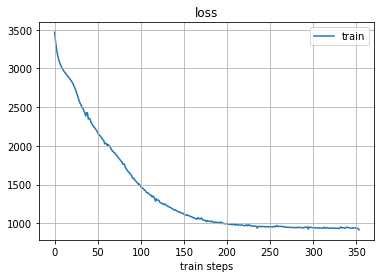

KeyboardInterrupt: 

In [230]:
model = GlowModel(32, 32, 1, 18, 3).to(device)
train(model, optim.Adam(model.parameters()), 10)

In [231]:
img = train_dataset[1][0]
out, logdet, z = model.forward(img[None, ...].to(device), 0, [])

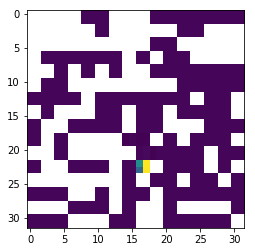

In [240]:
new_z = [torch.randn_like(z_) for z_ in z]
res = model.reverse(None, new_z)
plt.imshow(res[0].detach().cpu().numpy()[0, 0])

In [239]:
norm = torch.distributions.MultivariateNormal(torch.zeros(1024).to(device), torch.eye(1024).to(device))

In [233]:
norm.log_prob(torch.cat([z_.contiguous().view(1, -1) for z_ in z], 1))

tensor([-951.0001], device='cuda:0', grad_fn=<ThSubBackward>)

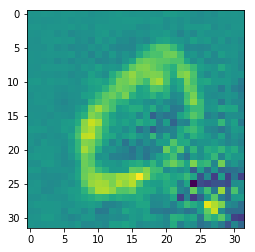

In [236]:
z[-1][-1, -1, -1, -1] += 0.1
res = model.reverse(None, z)
plt.imshow(res[0].detach().cpu().numpy()[0, 0])

In [241]:
img[0].numpy() - res[0].detach().cpu().numpy()[0, 0]

array([[           nan,            nan,            nan, ...,
         4.1839802e+01, -8.8481301e-01, -6.7619138e+00],
       [           nan,            nan,            nan, ...,
        -9.8741974e+01, -7.6046646e+01, -7.4282364e+01],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,  4.3142246e+03,  5.3680630e+03],
       [ 1.3794981e+01,  2.4369631e+00,  4.0294285e+01, ...,
        -2.0914536e+03,            nan,            nan],
       [ 1.7305077e+01,  2.0377693e+01,  1.3906331e+01, ...,
        -4.0932659e+03,            nan,            nan]], dtype=float32)